# Suave demo notebook: BAO basis on a periodic box

Hello! In this notebook we'll show you how to use suave, an implementation of the Continuous-Function Estimator, with a basis based on the standard baryon acoustic oscillation (BAO) fitting function.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import Corrfunc
from Corrfunc.io import read_lognormal_catalog
from Corrfunc.theory.DDsmu import DDsmu
from Corrfunc.theory.xi import xi
from Corrfunc.utils import evaluate_xi
from Corrfunc.utils import trr_analytic
from Corrfunc.bases import bao_bases
from colossus.cosmology import cosmology

In [2]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 8),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize}
pylab.rcParams.update(params)
plt.ion()

## Load in data

We'll demonstrate with a low-density lognormal simulation box, which we've included with the code. We'll show here the box with 3e-4 ($h^{-1}$Mpc)$^{-3}$, but if you're only running with a single thread, you will want to run this notebook with the 1e-4 ($h^{-1}$Mpc)$^{-3}$ box for speed. (The code is extremely parallel, so when you're running for real, you'll definitely want to bump up the number of threads.)

In [3]:
x, y, z = read_lognormal_catalog(n='2e-4')
boxsize = 750.0
nd = len(x)
print("Number of data points:",nd)

Number of data points: 85827


We don't need a random catalog for this example, as we'll use a periodic box such that we can calculate the random-random (and data-random) term analytically.

## Construct BAO basis

We will use a basis that is based on the standard BAO fitting function. It starts from the correlation function for a given cosmology, with the freedom for a scale shift using a scale dilation parameter $\alpha$. It includes a term that is the derivative of the correlation function with respect to $\alpha$, linearizing around this value. There are also nuisance parameter terms. For a full explanation, see [our paper](https://arxiv.org/abs/2011.01836).

To construct the BAO basis, we'll need to choose the r-range, as well as the redshift and bias. We can also select the cosmology, using the Colossus package. Note that we can also use a custom cosmology; see the [Colossus docs](https://bitbucket.org/bdiemer/colossus/src/master/). 

We also select our initial guess for the scale dilation parameter $\alpha_\mathrm{guess}$. A value of 1.0 means that we will not shift the correlation function, so let's start there. We also choose $k_0$, the initial magnitude of the partial derivative term.

In [4]:
rmin = 40
rmax = 150
cosmo = cosmology.setCosmology('planck15')
redshift = 1.0
bias = 2.0
alpha_guess = 1.0
k0 = 0.1
projfn = 'bao_basis.dat'
bases = bao_bases(rmin, rmax, projfn, cosmo_base=cosmo, alpha_guess=alpha_guess, k0=k0, 
                  ncont=2000, redshift=0.0, bias=1.0)

Plotting the bases, we see that the dark green basis is the correlation function for the given cosmology (and redshift and bias). It depends on the scale shift `alpha_guess` parameter; the default `alpha_guess=1.0`, meaning no shift.

The next-darkest green is the derivative with respect to the base cosmology. It depends on the dalpha and k0 parameters (we have just used the defaults here). 

The other bases are nuisances parameters to marginalize over the broadband shape of the correlation function. We can also set the initial magnitudes of these by passing the `k1`, `k2`, and `k3` parameters.

Text(0, 0.5, 'BAO basis functions $f_k(r)$')

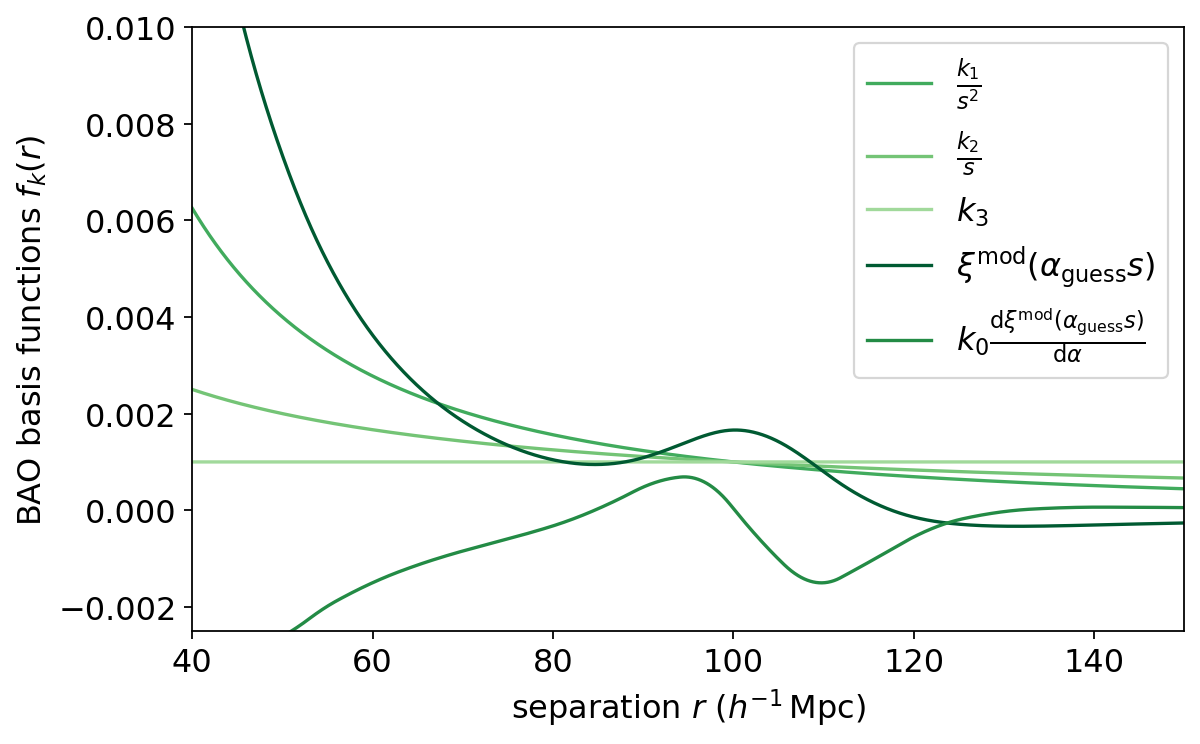

In [5]:
plt.figure(figsize=(8,5))
bao_base_colors = ['#41ab5d', '#74c476', '#a1d99b', '#005a32', '#238b45'] #from https://colorbrewer2.org/#type=sequential&scheme=Greens&n=8, last 5 out of 8
bao_base_names = [r'$\frac{k_1}{s^2}$', r'$\frac{k_2}{s}$', r'$k_3$', 
                  r'$\xi^\mathrm{mod}(\alpha_\mathrm{guess} s)$', 
                  r'$k_0 \frac{\mathrm{d} \xi^\mathrm{mod}(\alpha_\mathrm{guess} s)}{\mathrm{d} \alpha}$']
r = bases[:,0]
base_vals = bases[:,1:]
for i in range(base_vals.shape[1]):
    plt.plot(r, base_vals[:,i], label=bao_base_names[i], color=bao_base_colors[i])
    
plt.legend()
plt.xlim(rmin, rmax)
plt.ylim(-0.0025, 0.01)
plt.xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
plt.ylabel('BAO basis functions $f_k(r)$')

## Suave with a BAO basis

We set the suave parameters. The BAO basis we created is a file with a set of basis values at each separation r, so we use `proj_type=generalr`. We are also assuming a periodic box. We want the 3D correlation function, so we can use `DDsmu` with a single giant mu bin.

In [6]:
nthreads = 4
# Need to give a dummy r_edges for compatibility with standard Corrfunc.
# But we will use this later to compute the standard xi, so give something reasonable.
r_edges = np.linspace(rmin, rmax, 15)
mumax = 1.0
nmubins = 1
periodic = True
proj_type = 'generalr'
ncomponents = base_vals.shape[1]

In [7]:
dd_res_bao, dd_bao, _ = DDsmu(1, nthreads, r_edges, mumax, nmubins, x, y, z, 
                           boxsize=boxsize, periodic=periodic, proj_type=proj_type,
                           ncomponents=ncomponents, projfn=projfn)

Because we are working with a periodic box, we can compute the v_RR and T_RR terms analytically. From those we can compute the amplitudes. Note that we are using Landy-Szalay here, but the v_DR term is equal to the v_RR term for a periodic box, so we don't need to compute it and the LS numerator reduces to v_DD - v_RR.

In [8]:
volume = boxsize**3
rr_ana_bao, trr_ana_bao = trr_analytic(rmin, rmax, nd, volume, ncomponents, proj_type, projfn=projfn)

numerator = dd_bao - rr_ana_bao
amps_ana_bao = np.linalg.solve(trr_ana_bao, numerator) # Use linalg.solve instead of actually computing inverse!

We can then evaluate the correlation function using these amplitudes at any set of r values:

In [9]:
r_fine = np.linspace(rmin, rmax, 2000)
xi_ana_bao = evaluate_xi(amps_ana_bao, r_fine, proj_type, projfn=projfn)

Let's also compute the standard correlation function for comparison:

In [10]:
xi_res = xi(boxsize, nthreads, r_edges, x, y, z, output_ravg=True)
r_avg, xi_standard = xi_res['ravg'], xi_res['xi']

And plot the results:

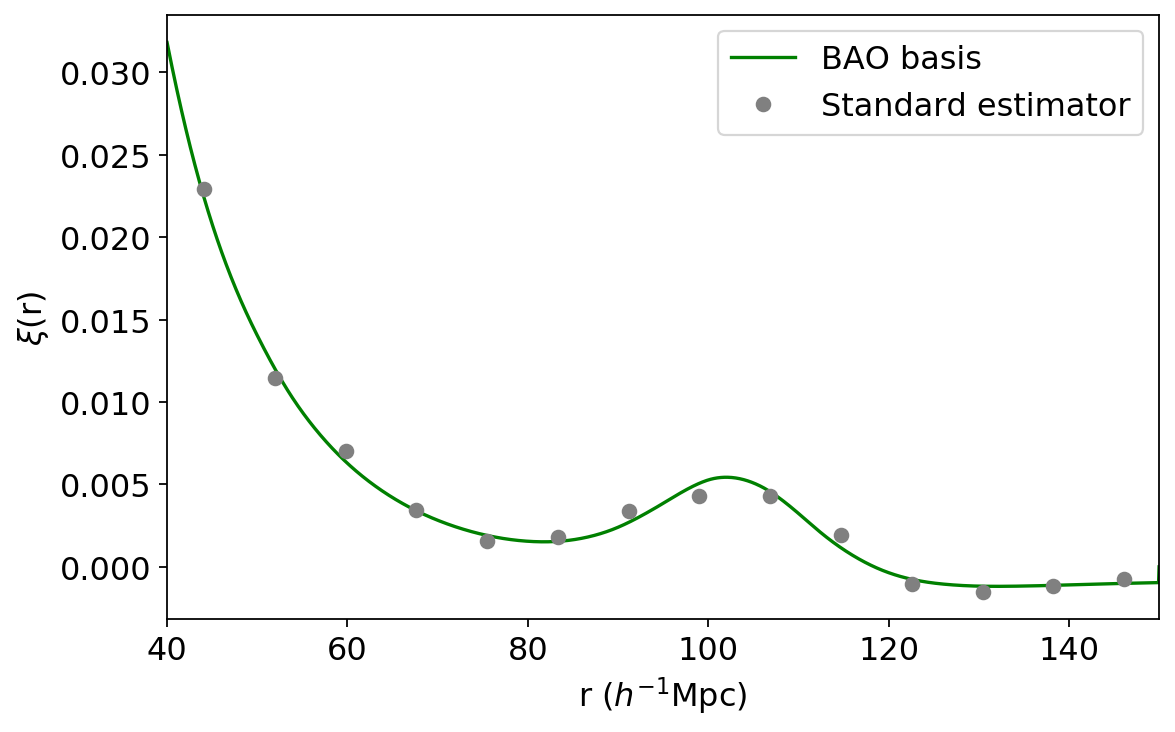

In [11]:
plt.figure(figsize=(8,5))
plt.plot(r_fine, xi_ana_bao, color='green', label='BAO basis')
plt.plot(r_avg, xi_standard, marker='o', ls='None', color='grey', label='Standard estimator')
plt.xlim(rmin, rmax)
plt.xlabel(r'r ($h^{-1}$Mpc)')
plt.ylabel(r'$\xi$(r)')
plt.legend()

Voila, a nice, continuous, well-motivated correlation function!

## Recovering the scale dilation parameter $\alpha$

We can read the estimated value of $\alpha$ directly from our amplitudes. The amplitude of the derivative term (let's call it C) is the amount that we need to shift $\alpha$ from our initial guess $\alpha_\mathrm{guess}$, moderated by $k_0$. Explicitly,
$$ \hat{\alpha} = \alpha_\mathrm{guess} + C \, k_0 $$

In [12]:
C = amps_ana_bao[4]
alpha_est = alpha_guess + C*k0
print(f"alpha_est = {alpha_est:.4f}")

alpha_est = 0.9548


So we found that the best fit to the data is not the initial cosmology, but that correlation function shifted by this factor. 

This is a pretty signficant shift, so the right thing to do is perform an iterative procedure to converge on the best-fit alpha. To do this, the next time around we pass `alpha_guess = alpha_est`. Then we'll get a new value for `alpha_est`, and can repeat the process until some criterion is reached (e.g. the fractional change between `alpha_est` for subsequent iterations dips below some threshold). See [our paper](https://arxiv.org/abs/2011.01836) for details.

Finally, remember to clean up the basis function file:

In [13]:
os.remove(projfn)